# Project Notebook IV: Supervised Learning with SVM with Hyperparameter Tuning as Benchmark

David Chen

In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
import boto3

In [2]:
## My custom helper functions
from helpers import *

## Step 1. Sagemaker Resources & Processed+FeatureSelected Data Saved in S3

In [3]:
sagemaker_session = sagemaker.Session()
sagemaker_session

In [4]:
role = sagemaker.get_execution_role()
role

'arn:aws:iam::644307290749:role/service-role/AmazonSageMaker-ExecutionRole-20210527T073969'

In [5]:
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-us-west-1-644307290749'

In [6]:
## Load processed, L1-selected features:
genes = pd.read_csv(get_s3_uri("assets/processed_data/genes_l1_selected.csv", bucket), index_col=0)
genes.shape

(999, 33)

In [7]:
## Load processed patient annotations (with defined class label):
clinical = pd.read_csv(get_s3_uri("assets/processed_data/clinical.csv", bucket))
clinical.index = clinical['Sample ID'].values
clinical.shape

(999, 15)

In [8]:
## Check to see if patient IDs in the 2 DataFrames match
assert all(genes.index == clinical.index)

In [9]:
y = clinical["Label"].astype(int)

## Step 2. Train-val-test split for Hyperparameter Tuning

Here, I will split the data into the following sets:

* Training Set (for Hyperparameter Tuning)
* Validation Set (Hyperparameter Tuning)
* Test Set (no labels, just features)

The approach will match that of the main model XGBoost as closely as possible, including:

* Maximum 20 candidates for Random Search
* Identical 100 test set examples

In [10]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(genes, y, test_size=100, random_state=42)

In [11]:
## Check class weights: inverse proportion of prevalence
## n_samples / (n_classes * np.bincount(y))
## No need to manually specify weights in sklearn. Simply run class_weight='balanced'
## See sklearn doc: scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

class_weights = len(y) / (2 * np.bincount(y))
class_weights #balanced class weights

array([0.56504525, 4.34347826])

In [12]:
## Relative positive class weight
class_weights[1] / class_weights[0]

7.6869565217391305

In [13]:
## Note that these weights equal to the format used by Sagemaker XGBoost
## See doc: docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
sum(y == 0) / sum(y == 1)

7.6869565217391305

## Step 3. Train SVM with Hyperparameter Tuning

Use the same strategy here as in XGBoost

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from scipy import stats

NUM_CANDIDATES = 20
SVM_PARAMS = {'C': stats.expon(scale=100), 'gamma': stats.expon(scale=0.1)}

In [15]:
## Use hold-out validation instead of cross validation for Random Search
## so that it matches with my strategy used for XGBoost
## see https://stackoverflow.com/questions/62656660

idx_validation = np.random.choice(range(Xtrain.shape[0]), size=100)
idx_train = np.setdiff1d(range(Xtrain.shape[0]), idx_validation)

In [16]:
random_search = RandomizedSearchCV(
    SVC(probability=True, kernel="rbf", class_weight='balanced'), 
    param_distributions = SVM_PARAMS, 
    n_iter = NUM_CANDIDATES,
    cv = [(idx_train, idx_validation)], #hold out validation
    scoring = "roc_auc"
)

random_search.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=[(array([  0,   1,   2,   4,   5,   6,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  34,  35,  36,  37,  38,  39,  40,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  58,
        59,  60,  61,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  80,  81,  82,  85,  86,  87,  88,
        89,  90,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118...
        93, 449, 535, 723, 264, 620,  57,   3, 629, 778, 413, 452, 845,
       546, 308,  83, 734, 676, 801, 682, 635, 377, 542, 699, 159, 233,
       837, 356,  79, 417, 726, 319,  33, 424, 221]))],
                   estimator=SVC(class_weight='balanced', probability=True),
                   n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object

In [17]:
df_tune = pd.DataFrame({
    "Hyperparam C": random_search.cv_results_["param_C"],
    "Hyperparam gamma": random_search.cv_results_["param_gamma"],
    "mean_AUC_score": random_search.cv_results_['mean_test_score']
})

df_tune.sort_values(by="mean_AUC_score", ascending=False, inplace=True)
df_tune

,Hyperparam C,Hyperparam gamma,mean_AUC_score
17,124.999,0.00404266,0.907048
10,3.59612,0.0183093,0.893769
14,63.8943,0.0264297,0.893769
5,6.13966,0.00733784,0.892748
4,22.1138,0.049096,0.892748
7,116.441,0.0283545,0.892748
8,48.8439,0.0271356,0.892748
13,76.3303,0.0545992,0.890705
9,162.677,0.0449379,0.890705
0,4.847,0.0468231,0.890705


In [18]:
## Export a copy
directS3Save(df_tune, bucket, "assets/svm-hpo-results.csv")

In [19]:
random_search.best_score_ #double-check

0.9070480081716036

### Show evaluation metrics on the hold-out Test Set

In [20]:
## Retrieve the best model:
svm = random_search.best_estimator_

In [21]:
yTestScore = svm.predict_proba(Xtest)

In [22]:
yTestPred = svm.predict(Xtest)

In [23]:
print(metrics.classification_report(ytest, yTestPred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        89
           1       0.62      0.73      0.67        11

    accuracy                           0.92       100
   macro avg       0.79      0.84      0.81       100
weighted avg       0.93      0.92      0.92       100



In [24]:
## Confusion matrix
metrics.confusion_matrix(ytest, yTestPred)

array([[84,  5],
       [ 3,  8]])

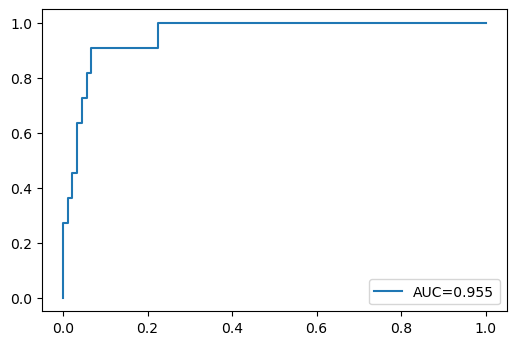

In [25]:
plot_roc(ytest, yTestScore[:,1])